In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and unzip dataset

In [3]:
dataset = "drive/MyDrive/DeepProject/Image_caption_generator_Dataset.zip"
!cp "{dataset}" .
!unzip -q Image_caption_generator_Dataset.zip
!rm Image_caption_generator_Dataset.zip

# Load the VGG16

In [4]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output) # Recreate the model
print(model.summary()) #print the summery

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# Extract features


In [5]:
data = {}
Image_path = os.path.join('Images')

for i in tqdm(os.listdir(Image_path)):

  image_file = Image_path + '/' + i
  image = load_img(image_file,target_size = (224,224))# load the image from file
  image = img_to_array(image) #convert to numpy array
  image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2]) # We have RGB images, so take 3 parameters
  image = preprocess_input(image)
  feature = model.predict(image, verbose = 0) #Extract features
  ID = i.split('.')[0]
  data[ID] = feature # store image_id


  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
save_file = "drive/MyDrive/Project"

#save features using pickle
pickle.dump(data,open(os.path.join(save_file,'Image_features.pkl'), 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Project/Image_features.pkl'

# Load caption file

In [7]:
with open (os.path.join('captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read() # read all the data

In [8]:
#create mapping of image to captions
map_img = {}
#process lines
for l in tqdm(captions_doc.split('\n')):
  #split the line by comma
  x = l.split(',')

  if len(l)<2:
    continue
  ID,caption = x[0],x[1]
  #remove extenstion
  ID = ID.split('.')[0]
  #convert caption list to string
  caption = " ".join(caption)
  #create list if needed
  if ID not in map_img:
    map_img[ID] = []

  #store the caption
  map_img[ID].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
#Example image caption
map_img['1000268201_693b08cb0e']

['A   c h i l d   i n   a   p i n k   d r e s s   i s   c l i m b i n g   u p   a   s e t   o f   s t a i r s   i n   a n   e n t r y   w a y   .',
 'A   g i r l   g o i n g   i n t o   a   w o o d e n   b u i l d i n g   .',
 'A   l i t t l e   g i r l   c l i m b i n g   i n t o   a   w o o d e n   p l a y h o u s e   .',
 'A   l i t t l e   g i r l   c l i m b i n g   t h e   s t a i r s   t o   h e r   p l a y h o u s e   .',
 'A   l i t t l e   g i r l   i n   a   p i n k   d r e s s   g o i n g   i n t o   a   w o o d e n   c a b i n   .']

In [10]:
len(map_img)

8091

# Preprocess Images

In [11]:
import re
def recreate_caption(map_img):

  for key,cap in map_img.items():
    for i in range (len(cap)):
      #take one caption at a time
      caption = cap[i]

      #convert to lower case
      caption = caption.lower()
      #delete digits, special chars
      caption = caption.replace('[^A-Za-z]','')
      #delete additional spaces
      caption = re.sub(r'(?<=\w) (?=\w)', '', caption)
      caption = re.sub(r'\s+', ' ', caption)
      #add tags to the caption
      caption = '<Caption:>' + " ".join([word for word in caption.split() if len(word)>1]) + '<***>'
      cap[i] = caption


In [12]:
recreate_caption(map_img)
map_img['1000268201_693b08cb0e']

['<Caption:>child in pink dress is climbing up set of stairs in an entry way<***>',
 '<Caption:>girl going into wooden building<***>',
 '<Caption:>little girl climbing into wooden playhouse<***>',
 '<Caption:>little girl climbing the stairs to her playhouse<***>',
 '<Caption:>little girl in pink dress going into wooden cabin<***>']

In [13]:
processed_cap = []
for i in map_img:
  for j in map_img[i]:
    processed_cap.append(j)

print("Number of captions:")
len(processed_cap)

Number of captions:


40455

In [14]:
print("First five captions:")
processed_cap[:5]

First five captions:


['<Caption:>child in pink dress is climbing up set of stairs in an entry way<***>',
 '<Caption:>girl going into wooden building<***>',
 '<Caption:>little girl climbing into wooden playhouse<***>',
 '<Caption:>little girl climbing the stairs to her playhouse<***>',
 '<Caption:>little girl in pink dress going into wooden cabin<***>']

In [15]:
# Maximum length of caption
maximum_length = max(len(caption.split()) for caption in processed_cap)
maximum_length

29

# Split train and test data

In [16]:
split_img = list(map_img.keys())
split = int(len(split_img)*0.9) #90% for training
train_data = split_img[:split]
test_data = split_img[split:]

In [17]:
len(train_data)

7281

In [18]:
len(test_data)

810

# Tokenize data

In [19]:
tokenize = Tokenizer()
tokenize.fit_on_texts(processed_cap)
V_size = len(tokenize.word_index) + 1

In [88]:


# Save the tokenizer to a file
with open('tokenize.pkl', 'wb') as f:
    pickle.dump(tokenize, f)

print("Tokenizer saved as tokenize.pkl")

Tokenizer saved as tokenize.pkl


# Model Creation

In [20]:
def create_model(dimention,maximum_length,V_size,embedded,lstm_units,dense_units,rate):
  in01 = Input(shape=(dimention,))
  feature_one = Dropout(rate)(in01)
  feature_two = Dense(256,activation='relu')(feature_one)

  #sequence model
  in02 = Input(shape=(maximum_length,))
  sequence_one = Embedding(V_size,embedded,mask_zero=True)(in02)
  sequence_two = Dropout(rate)(sequence_one)
  sequence_three = LSTM(lstm_units)(sequence_two)

  #Decoder model
  decoder_one = add([feature_two, sequence_three])
  decoder_two = Dense(dense_units, activation='relu')(decoder_one)
  outputs = Dense(V_size, activation='softmax')(decoder_two)

  model = Model(inputs=[in01, in02], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  return model



In [21]:
model = create_model(4096,maximum_length,V_size,256,256,266,0.4)

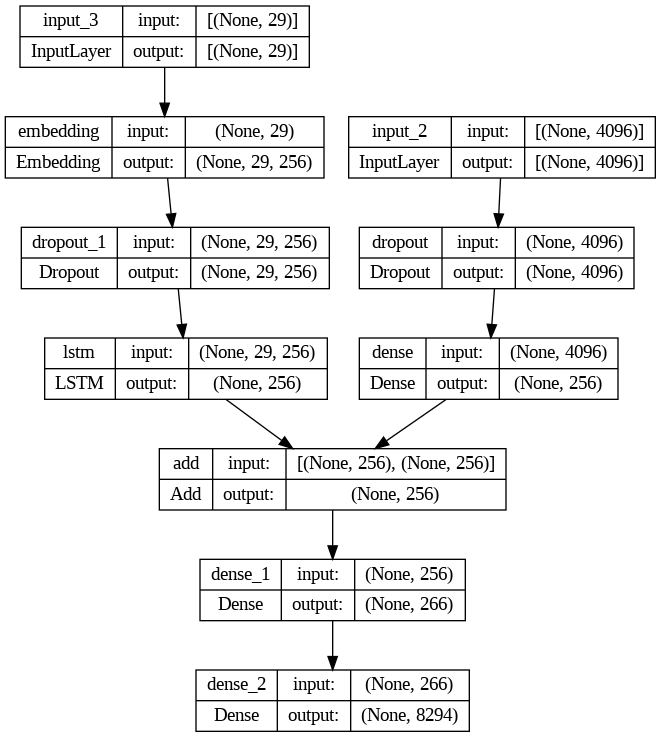

In [22]:
plot_model(model,show_shapes=True)

# Model Training

In [23]:
def Generate(key_values,map_img,data,tokenize, maximum_length,V_size,batch_size):
  #loop over images

  input01 = list()
  input02 = list()
  outputs = list()
  n = 0
  while 1:
    for key in key_values:
      n = n + 1
      cap = map_img[key]
      #process captions
      for i in cap:
        sequence = tokenize.texts_to_sequences([i])[0]
        #split the sequence into x,y pairs
        for j in range(1,len(sequence)):
          #split into input and output pairs
          input_sequence, output_sequence = sequence[:j], sequence[j]
          #pad input sequence
          input_sequence = pad_sequences([input_sequence], maxlen=maximum_length)[0]
          # encode output
          output_sequence = to_categorical([output_sequence],num_classes=V_size)[0]

          #store the sequences
          input01.append(data[key][0])
          input02.append(input_sequence)
          outputs.append(output_sequence)

      if n == batch_size:
        input01 = np.array(input01)
        input02 = np.array(input02)
        outputs = np.array(outputs)
        yield [input01,input02],outputs
        input01 = list()
        input02 = list()
        outputs = list()
        n = 0



In [24]:
epochs = 29
batch_size = 64
steps = len(train_data)// batch_size

for j in range(epochs):
  generator = Generate(train_data,map_img,data,tokenize,maximum_length,V_size,batch_size)
  #fir for one epoch
  model.fit(generator, epochs = 1,steps_per_epoch=steps,verbose=1)


113/113 [==============================] - 81s 712ms/step - loss: 2.0868


In [ ]:
#save the model
model.save(save_file + '/caption_model.h5')

# Generate captions to the image

In [25]:
def word_index(value,tokenize):
  for word,index in tokenize.word_index.items():
    if index == value:
      return word
  return None

In [26]:
def prediction(model,image,tokenize,maximim_length):
  #add start tag for generation process
  input_text = '<Caption:>'
  #iterate over the max length of sequence
  for i in range(maximum_length):
    #encode input sequence
    sequence = tokenize.texts_to_sequences([input_text])[0]
    #pad the sequence
    sequence = pad_sequences([sequence],maximum_length)
    #predict next word
    y_predict = model.predict([image,sequence],verbose=0)
    #get index with high probability
    y_predict = np.argmax(y_predict)
    #convert index to word
    word = word_index(y_predict,tokenize)
    #stop if word not found
    if word is None:
      break
    #append word as input for generating next word
    input_text += " " + word
    #stop if we reach end tag
    if word == '<***>':
      break
  return input_text

# Test with validation data

In [27]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu_score(test_data, map_img, model, data, tokenize, maximum_length):

    #Calculate BLEU scores for predicted captions against actual captions.

    actual_value = list()
    predicted_value = list()

    for key in tqdm(test_data):
        # Get actual captions
        captions = map_img[key]
        actual_captions = [caption.split() for caption in captions]

        # Predict caption
        y = prediction(model, data[key], tokenize, maximum_length)
        y = y.split()

        # Append to lists
        actual_value.append(actual_captions)
        predicted_value.append(y)

    # Calculate BLEU scores
    bleu1 = corpus_bleu(actual_value, predicted_value, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual_value, predicted_value, weights=(0.5, 0.5, 0, 0))

    return bleu1, bleu2


In [28]:
bleu1, bleu2 = calculate_bleu_score(test_data, map_img, model, data, tokenize, maximum_length)
print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.19374485596707816
BLEU-2: 0.1010494384115435


In [47]:
import matplotlib.pyplot as plt

def plot_bleu_scores(bleu1, bleu2):
    # Interpret scores
    def interpret_score(score):
        if score > 0.6:
            return "Excellent"
        elif score > 0.4:
            return "Good"
        elif score > 0.2:
            return "Fair"
        else:
            return "Poor"

    bleu1_interpretation = interpret_score(bleu1)
    bleu2_interpretation = interpret_score(bleu2)

    # Create bar plot
    bleu_scores = [bleu1, bleu2]
    labels = ['BLEU-1', 'BLEU-2']
    colors = ['blue', 'green']

    plt.bar(labels, bleu_scores, color=colors)
    plt.xlabel('BLEU Score Type')
    plt.ylabel('Score')
    plt.title('BLEU Scores for Image Captioning')

    # Add text annotations for interpretations
    for i, score in enumerate(bleu_scores):
        plt.text(i, score + 0.01, f"{score:.2f} ({interpret_score(score)})", ha='center')

    plt.ylim(0, 1.0)  # Adjust y-axis limits based on your score range
    plt.show()



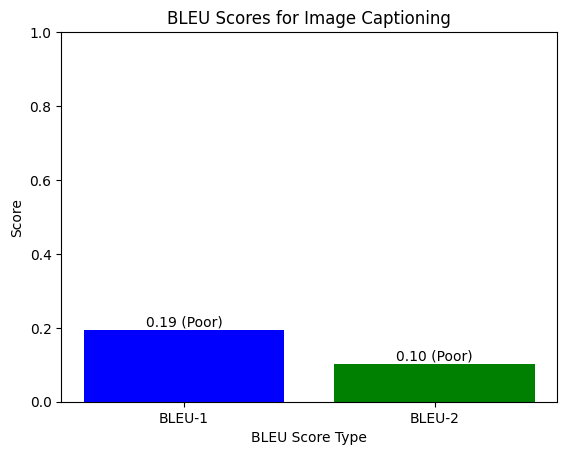

In [49]:
plot_bleu_scores(bleu1, bleu2)

In [32]:
for key in list(test_data)[:5]:  # Check first 5 examples
    captions = map_img[key]
    y = prediction(model, data[key], tokenize, maximum_length)
    print("Reference Captions:", captions)
    print("Predicted Caption:", y)


Reference Captions: ['<Caption:>man prepares to enter the red building<***>', '<Caption:>man walking around the corner of red building<***>', '<Caption:>man walks past red building with fake rocket attached to it<***>', '<Caption:>man walks under building with large rocket shaped sculpture<***>', '<Caption:>person walking by red building with jet on top of it<***>']
Predicted Caption: <Caption:> the skateboarder is in the background and white and white tarp and white skateboard midair on the top of the top of the ramp and skateboard going down the
Reference Captions: ['<Caption:>brown doberman is outside with stick in its mouth<***>', '<Caption:>brown dog shows his teeth<***>', '<Caption:>dog bites stick<***>', '<Caption:>dog is biting twig<***>', '<Caption:>dog with sharp teeth is chewing on stick outside<***>']
Predicted Caption: <Caption:> dog is digging in the air over stairs while another dog looks at the camera while his friend is pointing at the camera in the background with tra

# Visualize result

In [64]:
from PIL import Image
import matplotlib.pyplot as plt

def visualized_caption(image_name):
  image_path=image_name
  image = Image.open(image_path)


  y_pred = prediction(model,data['20141121-afp-MaithripalaSirisena'],tokenize,maximum_length)
  print( )
  print('-----------Predicted Caption-----------')
  print(y_pred)
  plt.imshow(image)

-----------Actual Caption-----------
<Caption:>man and woman are at catered dinner getting food<***>
<Caption:>an asian couple dip their plates at buffet<***>
<Caption:>young man and young woman serve food<***>
<Caption:>girl and boy serving food on plate<***>
<Caption:>two young people serve food<***>

-----------Predicted Caption-----------
<Caption:> man in white shirt and white shirt is sitting at catered dinner with food in the background and white and white dog in the background and the center bowls


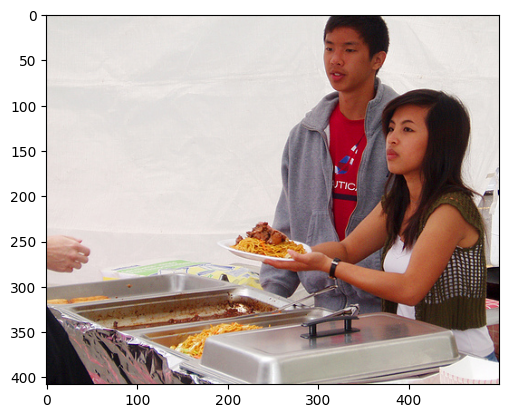

In [34]:
visualized_caption('141755292_7a0b3364cf.jpg')

-----------Actual Caption-----------
<Caption:>boy hits baseball with the bat<***>
<Caption:>boy swings baseball bat<***>
<Caption:>kid hits baseball during game<***>
<Caption:>little boy in teal uniform swinging baseball bat<***>
<Caption:>the boy in the blue shirt is swinging baseball bat towards ball as the boy in the red helmet waits to catch him out<***>

-----------Predicted Caption-----------
<Caption:> man in blue shirt and white shirt is playing baseball on the ground with stick in the background leaning to the ground in the background leaning to the other


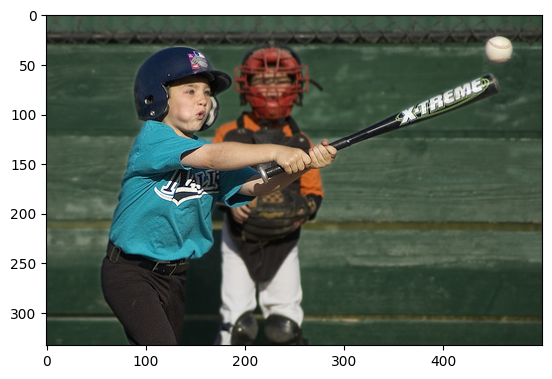

In [35]:
visualized_caption('141139674_246c0f90a1.jpg')

-----------Actual Caption-----------
<Caption:>boy in black helmet and red long sleeve shirt rides his motorbike over rocky stream<***>
<Caption:>man on motorcycle steers through swampy terrain<***>
<Caption:>man rides his bike over rocks and creek<***>
<Caption:>motocross bike is being ridden between markers in running stream<***>
<Caption:>person is dirt biking over rocks and water<***>

-----------Predicted Caption-----------
<Caption:> motocross bike is being ridden over rocks on the rocks on the rocks covered in the air over the rocks and red wheels over the rocks in the air


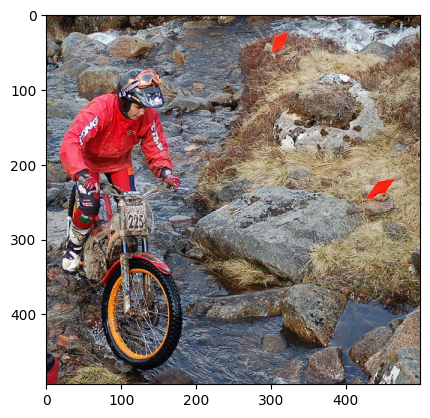

In [36]:
visualized_caption('143552829_72b6ba49d4.jpg')

-----------Actual Caption-----------
<Caption:>girl wearing pink hoodie looks through her camera<***>
<Caption:>woman in pink taking picture<***>
<Caption:>woman takes picture during the day<***>
<Caption:>young woman in pink hoodie takes picture<***>
<Caption:>woman with red curly hair taking pictures outside<***>

-----------Predicted Caption-----------
<Caption:> woman in pink hoodie is laughing on her face on her back in the distance while her she is wearing white hat and pink hat is on her face


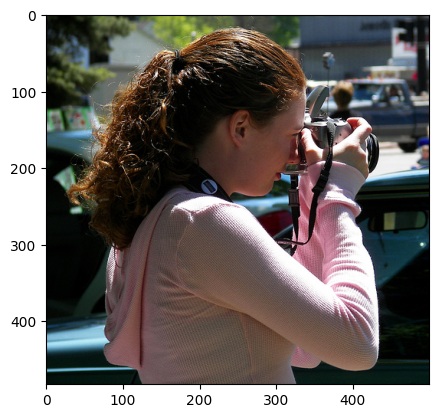

In [37]:
visualized_caption('150582765_bad8dec237.jpg')

-----------Actual Caption-----------
<Caption:>man is riding on red motorcycle<***>
<Caption:>motorcycle driver dressed in orange gear swerves to the right<***>
<Caption:>motorcyclist on red speed bike leans into sharp turn<***>
<Caption:>motorcyclist crouches low as he rounds turn<***>
<Caption:>this person is on red motorcycle<***>

-----------Predicted Caption-----------
<Caption:> motorcyclist in red suit swerves to the side of the road on racetrack and one he is wearing red helmet and helmet on his knee in the air and


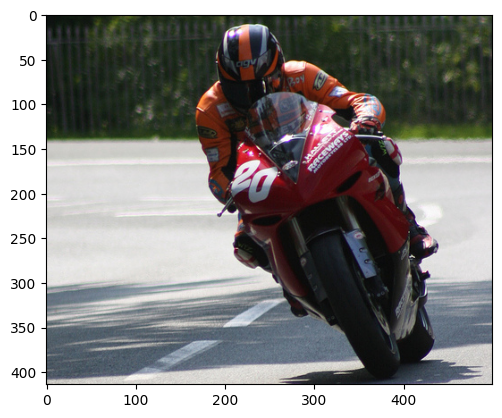

In [38]:
visualized_caption('166321294_4a5e68535f.jpg')

-----------Actual Caption-----------
<Caption:>football player in blue and one in red play in game<***>
<Caption:>sooners football player moves quickly on the field as another player runs<***>
<Caption:>the guy in the blue and white jersey is running<***>
<Caption:>the two players<***>
<Caption:>two men play football<***>

-----------Predicted Caption-----------
<Caption:> two men in field playing game in field hockey game and fans in stadium lock lock to the left members of him dressed in red watches him dressed in


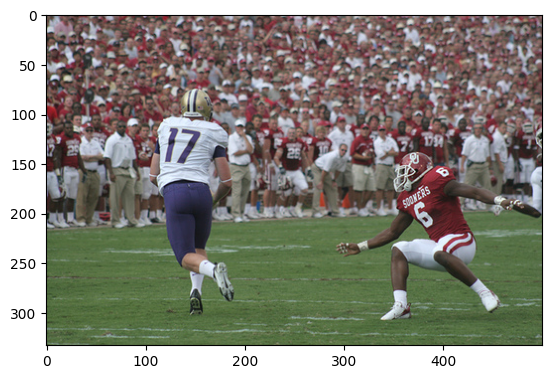

In [39]:
visualized_caption('241346971_c100650320.jpg')

-----------Actual Caption-----------
<Caption:>black dog in the middle of running or leaping<***>
<Caption:>black dog is running quickly along the ground<***>
<Caption:>rottweiler running<***>
<Caption:>the brown and black dog sprints across the snow<***>
<Caption:>there is black and tan dog bounding through the air<***>

-----------Predicted Caption-----------
<Caption:> black dog wearing blue collar and blue collar is jumping in the air on the beach edge in the grass with blue and blue toy in its mouth and


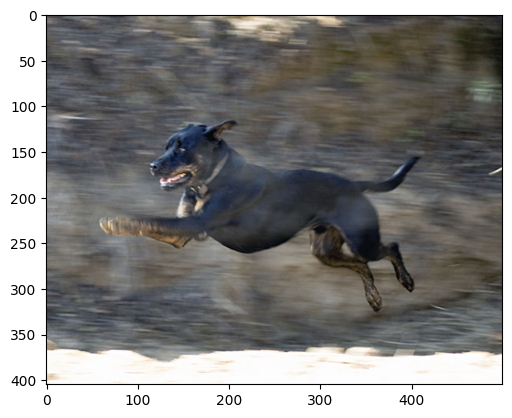

In [40]:
visualized_caption('326456451_effadbbe49.jpg')

-----------Actual Caption-----------
<Caption:>dog is chasing another dog carrying toy<***>
<Caption:>dog runs down beach holding yellow toy while another chases it<***>
<Caption:>dog with yellow toy is being chased by another dog<***>
<Caption:>one dog is chasing another dog that is carrying something in its mouth along the beach<***>
<Caption:>one white and tan dog is chasing another white and brown dog who has toy in its mouth<***>

-----------Predicted Caption-----------
<Caption:> dog splashes in the water while holding something in its mouth wide open to them in the middle of it is holding something up to it in its mouth


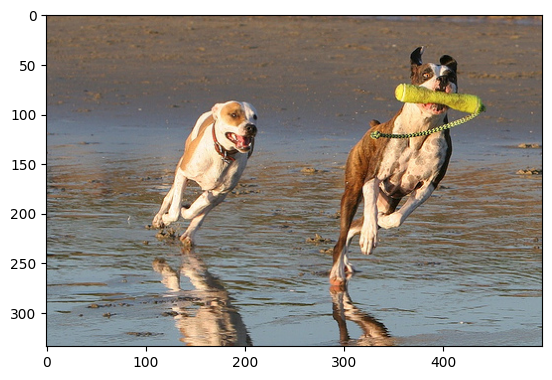

In [41]:
visualized_caption('364213568_7f83e7d144.jpg')

-----------Actual Caption-----------
<Caption:>dog bites an object offered by person<***>
<Caption:>dog playing with dog toy as someone tries to pull it from its mouth<***>
<Caption:>golden retriever plays with toy<***>
<Caption:>the photographer is playing tug of war with dog<***>
<Caption:>two dogs fighting for the same chew toy<***>

-----------Predicted Caption-----------
<Caption:> white dog is carrying stick in its mouth while walking through the grass with something camera in its mouth while its owners look on its leash in its mouth


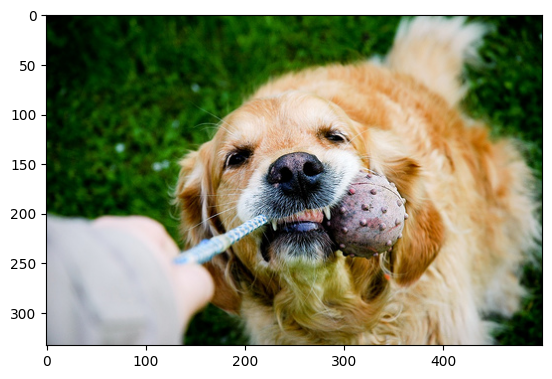

In [50]:
visualized_caption('468608014_09fd20eb9b.jpg')

-----------Actual Caption-----------
<Caption:>fat woman wearing blue tank top and backpack<***>
<Caption:>an obese woman holding chili dog in her right hand<***>
<Caption:>woman holding giant hot dog covered with mustard<***>
<Caption:>woman in blue shirt with backpack eating hot dog<***>
<Caption:>woman in blue tank top eats chili cheese hot dog<***>

-----------Predicted Caption-----------
<Caption:> girl in blue tank top and white tank top is dancing in front of her girl in white shirt and white shirt and white shirt with hot hot air


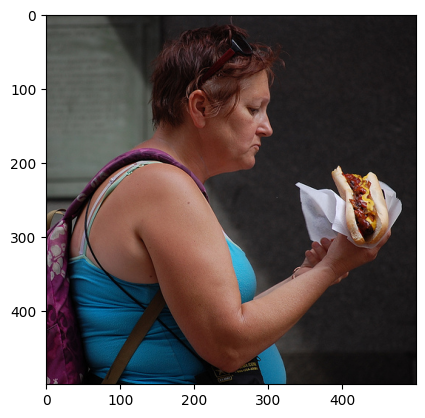

In [51]:
visualized_caption('3713882697_6dd30c7505.jpg')

-----------Actual Caption-----------
<Caption:>baby in baby seat wearing red beanie that says love<***>
<Caption:>baby in red hat sitting in stroller is holding doll<***>
<Caption:>baby with red hat sits in his stroller<***>
<Caption:>litttle baby plays with her teddy bear<***>
<Caption:>baby wearing red hat in car seat<***>

-----------Predicted Caption-----------
<Caption:> baby in red beanie is sitting in stroller seat in stroller seat in stroller seat in stroller seat in stroller seat in stroller in stroller for love love bear


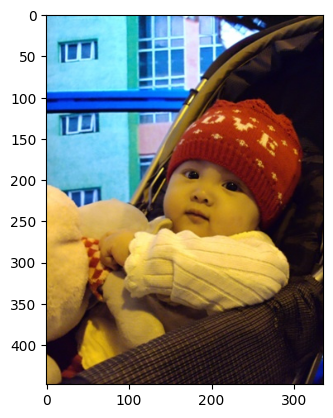

In [52]:
visualized_caption('3732728142_86364a706e.jpg')

-----------Actual Caption-----------
<Caption:>girl kicks ball<***>
<Caption:>little girl gives good kick to blue ball<***>
<Caption:>little girl in pink shirt kicks blue ball<***>
<Caption:>young girl kicking blue ball<***>
<Caption:>young girl in pink shirt kicking blue ball<***>

-----------Predicted Caption-----------
<Caption:> girl in red shirt kicking ball on the grass in field of lot of orange ball and ball on the ground in the background carrying stick in her shirt


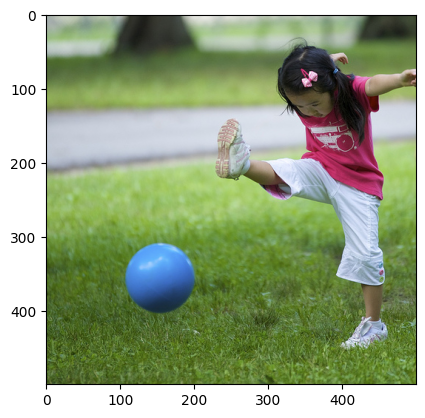

In [53]:
visualized_caption('3672940355_47f30e2b28.jpg')

In [69]:
from google.colab import files
uploaded = files.upload()

# Assuming you upload only one image, get its file name
image_path = next(iter(uploaded.keys()))

Saving 20141121-afp-MaithripalaSirisena.jpg to 20141121-afp-MaithripalaSirisena (1).jpg


In [89]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 29, 256)              2123264   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            